In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('df_daily_avg.csv')

In [3]:
df_day_shift = df.copy().shift(1)

In [4]:
df_year_rain_shift = df['Rainfall'].copy().shift(365)
df_year_rain_shift = df_year_rain_shift.rename('Rainfall_LastYear')

In [5]:
for col in df_day_shift.columns:
    df_day_shift = df_day_shift.rename(columns = {str(col):str(col+'_lag')})

In [6]:
df = pd.concat([df, df_day_shift], axis=  1)
df= df.drop(columns = 'Date_lag')
df = pd.concat([df, df_year_rain_shift], axis=  1)

In [7]:
df.isna().sum()

Date                             0
Dry Bulb Temperature             0
Dew Point Temperature            0
Apparent Temperature             0
Relative Humidity                2
Wind Direction                   0
Average Wind Speed             126
Wind Gust                        0
Mean Sea Level Pressure          0
Rainfall                         0
Dry Bulb Temperature_lag         1
Dew Point Temperature_lag        1
Apparent Temperature_lag         1
Relative Humidity_lag            3
Wind Direction_lag               1
Average Wind Speed_lag         127
Wind Gust_lag                    1
Mean Sea Level Pressure_lag      1
Rainfall_lag                     1
Rainfall_LastYear              365
dtype: int64

In [8]:
df = df.dropna()

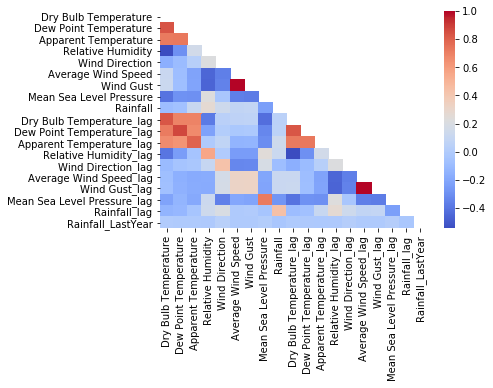

In [9]:
sns.heatmap(df.corr(), mask = np.triu(df.corr()),cmap= 'coolwarm')

In [10]:
#feature encoding 
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [11]:
#Create seasons
df['Season'] = 0
for i in df['Month'].iteritems():
    if  i[1]== 12 or i[1] < 3 :
        df['Season'][i[0]] = 'Summer' 
    elif 3 <= i[1] < 6:
        df['Season'][i[0]] = 'Autumn' 
    elif 6 <= i[1] < 9 :
        df['Season'][i[0]] = 'Winter'
    else:
        df['Season'][i[0]] = 'Spring'
        
df_season =  pd.get_dummies(df['Season'])
df = pd.concat([df, df_season], axis = 1)
df = df.drop(columns = 'Season')

In [12]:
df.columns

Index(['Date', 'Dry Bulb Temperature', 'Dew Point Temperature',
       'Apparent Temperature', 'Relative Humidity', 'Wind Direction',
       'Average Wind Speed', 'Wind Gust', 'Mean Sea Level Pressure',
       'Rainfall', 'Dry Bulb Temperature_lag', 'Dew Point Temperature_lag',
       'Apparent Temperature_lag', 'Relative Humidity_lag',
       'Wind Direction_lag', 'Average Wind Speed_lag', 'Wind Gust_lag',
       'Mean Sea Level Pressure_lag', 'Rainfall_lag', 'Rainfall_LastYear',
       'Month', 'Day', 'Year', 'Autumn', 'Spring', 'Summer', 'Winter'],
      dtype='object')

In [13]:
#Modelling 
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from joblib import load, dump
import sklearn.linear_model

In [14]:
df = df.query("Date >= Timestamp('2014-02-16 00:00:00')") #Start from point where there are limited gaps in the data

In [15]:
#Create copies of the data frame 
x_df = df.copy().drop(columns = ['Rainfall', 'Date'])
y_df = df['Rainfall'].copy()

In [17]:
#import an appropriate splitting object 
class BlockedTimeSeriesSplit(): #from packt
    def __init__(self, n_splits = 5):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

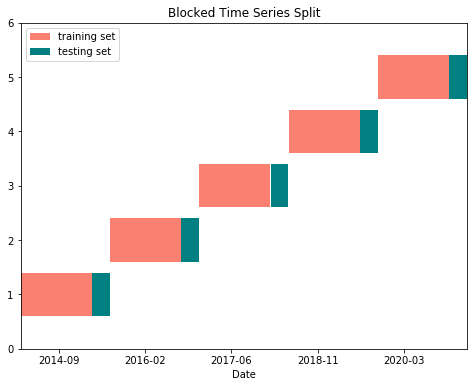

In [18]:
import matplotlib.dates as mdates
import matplotlib.pyplot
fig, ax = plt.subplots(figsize = (8,6))
btss = BlockedTimeSeriesSplit()
y_ax = 1
for train, test in btss.split(x_df, y_df):
    train_df, test_df = df[min(train):max(train)], df[min(test):max(test)]
    plt.barh(left= train_df['Date'], width = 1, y = y_ax, color ='salmon', label ='training set')
    plt.barh(left = test_df['Date'],y = y_ax, width = 1, color = 'teal', label = 'testing set')
    y_ax += 1
    
ax.set_title('Blocked Time Series Split')
ax.set_xlabel('Date')
ax.set_ylim(ymin = 0, ymax = 6)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(['training set','testing set'], loc = 'best')

ax.set_rasterized(True)
plt.savefig('split.jpeg')

In [19]:
from sklearn.model_selection import cross_val_score
#Cross validates then averages the metrics 
def cross_val(model):
    x_df, y_df = df.copy().drop(columns = ['Rainfall', 'Date']), df['Rainfall'].copy()
    mse = cross_val_score(model, x_df.values, y_df.values, cv=split, scoring='neg_mean_squared_error')
    r = cross_val_score(model, x_df.values, y_df.values, cv=split, scoring='r2')
    m_avg = 0
    r_avg  =0
    for i in mse:
        m_avg +=abs(i) 
    m_avg = m_avg/5
    for i in r:
        r_avg +=abs(i) 
    r_avg = r_avg/5
    return('Average MSE, Average r2:', m_avg, r_avg)

In [20]:
#intialise split
split = BlockedTimeSeriesSplit()

#Use a regularised model to account for high multicollinearity in lagged variables 
#Ard assumes a gamma distribution 
ard_reg = sklearn.linear_model.ARDRegression()

print(cross_val(ard_reg))

('Average MSE, Average r2:', 12.79788488952285, 0.34435410152803064)


In [21]:
#get the split indicies
index = []
for train, test in split.split(x_df,y_df):
    index +=[train, test]

train1, test1 = df[min(index[0]):max(index[0])],df[min(index[1]):max(index[1])]
train2, test2 = df[min(index[2]):max(index[2])],df[min(index[3]):max(index[3])]
train3, test3 = df[min(index[4]):max(index[4])],df[min(index[5]):max(index[5])]
train4, test4 = df[min(index[6]):max(index[6])],df[min(index[7]):max(index[7])]
train5, test5 = df[min(index[8]):max(index[8])],df[min(index[9]):max(index[9])]

index = [[train1, test1],[train2, test2], [train3, test3],[train4, test4],[train5, test5]]

In [22]:
#Plots all the predicitions against the actual data 
def predict_plot(model):
    prediction_lst = []
    actual_lst = []
    fig, ax  = plt.subplots(1, 5, figsize = (16,8))
    for i in range(len(index)):
        train_x, train_y = index[i][0], index[i][0]['Rainfall']
        test_x, test_y = index[i][1], index[i][1]['Rainfall']
        model.fit(train_x.drop(columns = ['Rainfall', 'Date']), train_y)
        
        ax[i].plot(test_x['Date'], test_y, label ='actual')
        ax[i].plot(test_x['Date'], model.predict(test_x.drop(columns = ['Rainfall', 'Date'])), label ='predictions')

        
    fig.autofmt_xdate()
    ax[0].legend()

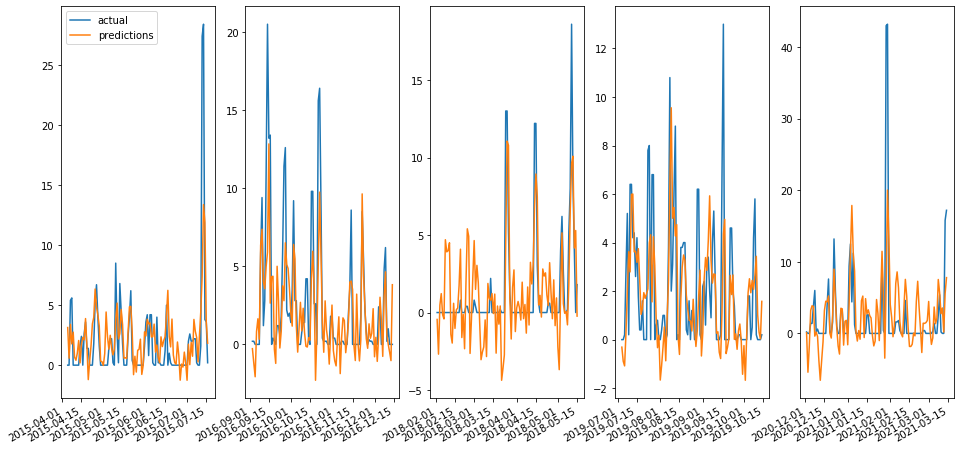

In [23]:
predict_plot(sklearn.linear_model.ARDRegression())

In [24]:
#Since there are negative predictions, and rainfall cannot be negative,
#a new model needs to be made to set negative predictions to 0
class PositiveARD_Regression(sklearn.linear_model.ARDRegression):
    
    def predict(self, X, return_std=False):
        """Predict using the linear model.
        In addition to the mean of the predictive distribution, also its
        standard deviation can be returned.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Samples.
        return_std : bool, default=False
            Whether to return the standard deviation of posterior prediction.
        Returns
        -------
        y_mean : array-like of shape (n_samples,)
            Mean of predictive distribution of query points.
        y_std : array-like of shape (n_samples,)
            Standard deviation of predictive distribution of query points.
        """
        y_mean = self._decision_function(X)
        for i in range(len(y_mean)):
            if y_mean[i] < 0:
                y_mean[i] = 0
        if return_std is False:
            return y_mean
        else:
            if self.normalize:
                X = (X - self.X_offset_) / self.X_scale_
            X = X[:, self.lambda_ < self.threshold_lambda]
            sigmas_squared_data = (np.dot(X, self.sigma_) * X).sum(axis=1)
            y_std = np.sqrt(sigmas_squared_data + (1. / self.alpha_))
            return y_mean, y_std

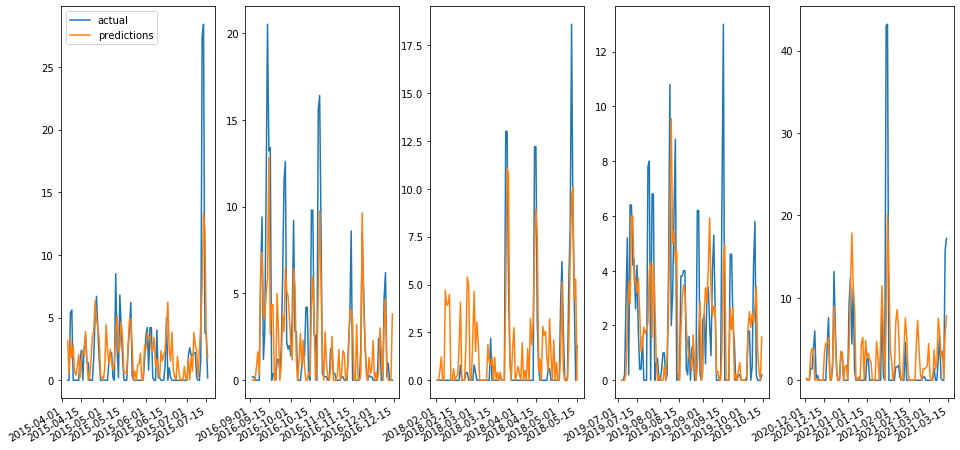

In [25]:
predict_plot(PositiveARD_Regression())

In [26]:
cross_val(PositiveARD_Regression())

('Average MSE, Average r2:', 12.064650852322512, 0.3871529788081546)

In [27]:
#Tune hyperparameters for Postive ARD model 

In [ ]:
pos_ard  =  PositiveARD_Regression()

#Maximum number of iterations
n_iter = [370,380,390,400,410,420,430]
#shape parameter for the Gamma distribution prior over the alpha parameter
alpha_1 = [0,.5,1,1.5,2]
#inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter.
alpha_2 = [7,8,9,10,11,12,13]
#shape parameter for the Gamma distribution prior over the lambda parameter
lambda_1 = [4e-05, 3e-05, 2e-05, 1e-05, 9e-06, 99e-7, 98e-7]
#inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter.
lambda_2 = [4e-06, 3e-06, 2e-06, 1e-06, 9e-07, 99e-8, 98e-8]
#threshold for removing (pruning) weights with high precision from the computation.
threshold_lambda = [1000,10000,100000]

param = {'n_iter': n_iter,
        'alpha_1': alpha_1,
        'alpha_2': alpha_2,
        'lambda_1': lambda_1,
        'lambda_2': lambda_2,
         'threshold_lambda':  threshold_lambda
        }
random  = RandomizedSearchCV(estimator = pos_ard, param_distributions = param,
                               cv = split, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error',
                             random_state =21, n_iter =1000).fit(x_df, y_df)
dump(random, 'pos_ard_random.joblib')

In [28]:
random =load('pos_ard_random.joblib')
random.best_params_

{'threshold_lambda': 100000,
 'n_iter': 380,
 'lambda_2': 4e-06,
 'lambda_1': 9.9e-06,
 'alpha_2': 8,
 'alpha_1': 2}

In [29]:
cross_val(PositiveARD_Regression().set_params(**random.best_params_))

('Average MSE, Average r2:', 11.98057412847658, 0.38927314128385865)

In [ ]:
# Conduct GridSearch
pos_ard  =  PositiveARD_Regression()
#Maximum number of iterations
n_iter = np.arange(100,450, 50)
#shape parameter for the Gamma distribution prior over the alpha parameter
alpha_1 = np.arange(2,10, 1.5)
#inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter.
alpha_2 = np.arange(5,9,1)
#shape parameter for the Gamma distribution prior over the lambda parameter
lambda_1 = [3e-05, 5e-05, 1e-05, 9e-06, 1e-06]
#inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter.
lambda_2 = [1e-06, 5e-06, 1e-05, 1e-04, 1e-03]
#threshold for removing (pruning) weights with high precision from the computation.
threshold_lambda = [80000,90000,100000]

param = {'n_iter': n_iter,
        'alpha_1': alpha_1,
        'alpha_2': alpha_2,
        'lambda_1': lambda_1,
        'lambda_2': lambda_2,
        'threshold_lambda': threshold_lambda}
grid = GridSearchCV(estimator = pos_ard, param_grid = param,
                               cv = split, verbose=2, n_jobs = -1, scoring = 'neg_mean_squared_error').fit(x_df, y_df)
dump(grid, 'pos_ard_gs.joblib')

In [30]:
grid =load('pos_ard_gs.joblib')
grid.best_params_

{'alpha_1': 20,
 'alpha_2': 3,
 'lambda_1': 9e-06,
 'lambda_2': 6e-06,
 'n_iter': 150,
 'threshold_lambda': 90000}

In [31]:
cross_val(PositiveARD_Regression().set_params(**grid.best_params_))

('Average MSE, Average r2:', 11.946222754358521, 0.3912391953388304)